In [2]:
print("ok all")

ok all


In [3]:
import os,sys
projject_root = os.path.abspath(os.path.join(os.getcwd(),".."))
sys.path.append(projject_root)

print(projject_root)

d:\Sunny_savitha\auto_rec\automated-research-report-generation


In [4]:
from research_and_analysts.utils.model_loader import ModelLoader


In [5]:
model_loader = ModelLoader()

{"timestamp": "2025-10-29T16:56:50.871575Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-10-29T16:56:50.871575Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-10-29T16:56:50.878518Z", "level": "warning", "event": "ASTRA_DB_API_ENDPOINT is missing from environment"}
{"timestamp": "2025-10-29T16:56:50.879847Z", "level": "warning", "event": "ASTRA_DB_APPLICATION_TOKEN is missing from environment"}
{"timestamp": "2025-10-29T16:56:50.881856Z", "level": "warning", "event": "ASTRA_DB_KEYSPACE is missing from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-10-29T16:56:50.881856Z", "level": "info", "event": "YAML config loaded"}


In [6]:
llm = model_loader.load_llm()

{"provider": "google", "model": "gemini-2.0-flash", "timestamp": "2025-10-29T16:56:50.897259Z", "level": "info", "event": "Loading LLM"}


In [7]:
llm.invoke("Hi").content

'Hi there! How can I help you today?'

In [8]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [9]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from IPython.display import Image, display

In [10]:
class Analyst(BaseModel):
    name:str = Field(description="Name of analyst.")
    role:str = Field(description="Role of analyst in context of topic")
    affiliation:str = Field(description="Primary affiliation of the analyst")
    description:str = Field(description="Description of the analyst focus, concerns and motives.")

    @property
    def persona(self)->str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

In [11]:
analyst = Analyst(
    name="Munavar",
    role="gen_ai eng",
    affiliation="AI Research Lab",
    description="I am genai eng"
)

In [12]:
analyst.name

'Munavar'

In [13]:
print(analyst.persona)

Name: Munavar
Role: gen_ai eng
Affiliation: AI Research Lab
Description: I am genai eng



In [14]:
class Perspective(BaseModel):
    analysts: List[Analyst] = Field(description="Comprehensive list of analyst with theor roles and affiliations.")

In [15]:
class GenerativeAnalystState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback:str
    analysts: List[Analyst]

In [16]:
GenerativeAnalystState(
    topic= "finance",
    max_analysts= 5,
    human_analyst_feedback="Give the real info"
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'Give the real info'}

In [17]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [18]:
def create_analyst(state:GenerativeAnalystState):
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")

    structured_llm = llm.with_structured_output(Perspective)
    system_message = analyst_instructions.format(
        topic = topic,
        max_analysts=max_analysts,
        human_analyst_feedback = human_analyst_feedback
    )
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analyst. ")])
    return {"analysts": analysts.analysts}

In [19]:
create_analyst(
 {'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'Give the real info'})

{'analysts': [Analyst(name='Ava Sterling', role='Quantitative Analyst', affiliation='Hedge Fund XYZ', description='Focuses on statistical modeling and algorithmic trading strategies to maximize returns and manage risk in financial markets.'),
  Analyst(name='Ben Carter', role='Market Strategist', affiliation='Global Investment Bank ABC', description='Analyzes macroeconomic trends and geopolitical events to forecast market movements and advise clients on investment opportunities.'),
  Analyst(name='Chloe Davis', role='Financial Regulation Expert', affiliation='Regulatory Compliance Agency', description='Monitors and interprets changes in financial regulations, assessing their impact on financial institutions and market participants.'),
  Analyst(name='Daniel Evans', role='Corporate Finance Advisor', affiliation='Mergers & Acquisitions Firm LMN', description='Specializes in evaluating corporate financial performance, advising on mergers, acquisitions, and restructuring strategies.'),
  A

In [20]:
def human_feedback(state):
    pass

In [21]:
def should_continue(state):
    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback:
        return "create_analyst"

In [22]:
builder = StateGraph(GenerativeAnalystState)

In [23]:
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback", human_feedback)

In [24]:
builder.add_edge(START, "create_analyst")
builder.add_edge("create_analyst","human_feedback")
builder.add_conditional_edges("human_feedback",
                         should_continue,
                         ["create_analyst",
                          END])

In [25]:
memory = MemorySaver()

In [26]:
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer = memory)

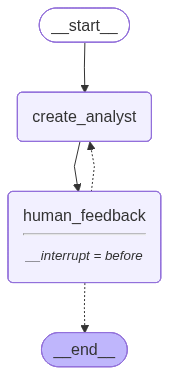

In [27]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [28]:
topic = "the benefits of adopting Langgraph as agent framework"
max_analysts = 4
thread = {"configurable":{"thread_id":1}}

In [29]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
              thread,
              stream_mode="values"):
    analysts = event.get("analysts",'')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Alice Thompson
Affiliation: Tech Solutions Inc.
Role: AI Infrastructure Engineer
Description: Focuses on the practical aspects of integrating Langgraph into existing systems, ensuring scalability and reliability. Concerned with the engineering challenges and performance bottlenecks.
--------------------------------------------------
Name: Bob Miller
Affiliation: Innovation Lab
Role: AI Research Scientist
Description: Interested in Langgraph's potential to advance AI research, particularly in complex reasoning and multi-agent systems. Motivated by pushing the boundaries of AI capabilities.
--------------------------------------------------
Name: Charlie Davis
Affiliation: Strategic Investments Corp.
Role: Business Strategist
Description: Evaluates the business value of Langgraph, considering its impact on efficiency, cost savings, and competitive advantage. Focuses on ROI and strategic alignment.
--------------------------------------------------
Name: Diana White
Affiliation: Eth

In [30]:
state = graph.get_state(thread)

In [31]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Alice Thompson', role='AI Infrastructure Engineer', affiliation='Tech Solutions Inc.', description='Focuses on the practical aspects of integrating Langgraph into existing systems, ensuring scalability and reliability. Concerned with the engineering challenges and performance bottlenecks.'), Analyst(name='Bob Miller', role='AI Research Scientist', affiliation='Innovation Lab', description="Interested in Langgraph's potential to advance AI research, particularly in complex reasoning and multi-agent systems. Motivated by pushing the boundaries of AI capabilities."), Analyst(name='Charlie Davis', role='Business Strategist', affiliation='Strategic Investments Corp.', description='Evaluates the business value of Langgraph, considering its impact on efficiency, cost savings, and competitive advantage. Focuses on ROI and strategic alignment.'), Analyst(name='Di

In [32]:
graph.update_state(thread,{"human_analyst_feedback":"add something from the startup perspective and focus on "}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b4e84-c41f-6c5d-8002-23bbc699a458'}}

In [33]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
              thread,
              stream_mode="values"):
    analysts = event.get("analysts",'')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Alice Thompson
Affiliation: Tech Solutions Inc.
Role: AI Infrastructure Engineer
Description: Focuses on the practical aspects of integrating Langgraph into existing systems, ensuring scalability and reliability. Concerned with the engineering challenges and performance bottlenecks.
--------------------------------------------------
Name: Bob Miller


Affiliation: Innovation Lab
Role: AI Research Scientist
Description: Interested in Langgraph's potential to advance AI research, particularly in complex reasoning and multi-agent systems. Motivated by pushing the boundaries of AI capabilities.
--------------------------------------------------
Name: Charlie Davis
Affiliation: Strategic Investments Corp.
Role: Business Strategist
Description: Evaluates the business value of Langgraph, considering its impact on efficiency, cost savings, and competitive advantage. Focuses on ROI and strategic alignment.
--------------------------------------------------
Name: Diana White
Affiliation: Ethics & AI Institute
Role: AI Ethics Advisor
Description: Examines the ethical implications of using Langgraph, including issues of bias, transparency, and accountability. Concerned with responsible AI development and deployment.
--------------------------------------------------
Name: Ava Chen
Affiliation: InnovateAI
Role: Startup CTO
Description: Focuses 

In [34]:
state = graph.get_state(thread)
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on ', 'analysts': [Analyst(name='Ava Chen', role='Startup CTO', affiliation='InnovateAI', description='Focuses on the practical benefits of Langgraph for startups, including rapid prototyping, cost-effectiveness, and scalability. Concerned with ease of integration and the learning curve for small teams.'), Analyst(name='Ben Carter', role='AI Research Scientist', affiliation='AcademiaAI', description="Interested in Langgraph's capabilities for complex agent orchestration, state management, and parallel execution.  Focuses on benchmarking Langgraph against other frameworks and exploring its theoretical limitations."), Analyst(name='Priya Sharma', role='Enterprise Architect', affiliation='GlobalTech Solutions', description='Evaluates Langgraph for enterprise-level deployments, focusing on security, compli

In [35]:
state.next

('human_feedback',)

In [36]:
further_feedback = "None"
graph.update_state(thread,{"human_analyst_feedback":further_feedback}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b4e84-e4b9-6c5f-8006-d92eca7ad682'}}

In [37]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [38]:
final_state.next

('create_analyst',)

## Second Workflow

In [39]:
import os
from dotenv import load_dotenv
load_dotenv()
tavily_api_key = os.getenv("TAVILY_API_KEY")


In [40]:
from langchain_community.tools import TavilySearchResults
tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)

tavily_search.invoke("LLM")


C:\Users\bsmun\AppData\Local\Temp\ipykernel_1944\3464101177.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)


[{'title': 'Large language model - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Large_language_model',
  'content': 'A large language model (LLM) is a language model trained with self-supervisedmachine learning on a vast amount of text, designed for natural language processing tasks, especially language generation.( The largest and most capable LLMs are generative pre-trained transformers (GPTs) and provide the core capabilities of chatbots such as ChatGPT, Gemini "Gemini (chatbot)") and Claude "Claude (language model)"). LLMs can be fine-tuned "Fine-tuning (deep learning)") for specific tasks or guided by [...] An LLM is a type of foundation model (large X model) trained on language. LLMs can be trained in different ways. In particular, GPT models are first pretrained to predict the next word on a large amount of data, before being fine-tuned._[citation needed_]\n\n### Cost\n\n[edit]\n\nImage 8 [...] They consist of billions to trillions of parameters and operate as general-pur

In [41]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="langgraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


In [42]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int
    context: Annotated[list, operator.add]
    analyst: Analyst
    interview: str
    sections: list

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrival")

In [43]:
def _state_map(state):
    """Return a dict-like mapping for the provided state.
    Accepts dicts, Pydantic v2 model instances (model_dump), Pydantic v1 (dict),
    or falls back to __dict__.
    """
    if isinstance(state, dict):
        return state
    # Pydantic v2
    if hasattr(state, "model_dump"):
        try:
            return state.model_dump()
        except Exception:
            pass
    # Pydantic v1
    if hasattr(state, "dict"):
        try:
            return state.dict()
        except Exception:
            pass
    # fallback: try __dict__ or return original
    return getattr(state, "__dict__", state)


In [44]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [45]:
print(analyst.persona)

Name: David Lee
Role: AI Product Manager
Affiliation: ProductAI
Description: Focuses on how Langgraph can accelerate the development and deployment of AI-powered products. Concerned with user experience, monitoring, and the ability to iterate quickly based on user feedback.



In [46]:
def generation_question(state:InterviewState):
    m = _state_map(state)
    analyst = m.get("analyst")
    messages = m.get("messages", [])

    system_messages = question_instructions.format(goals = analyst.persona if analyst is not None else "")
    question = llm.invoke([SystemMessage(content=system_messages)]+messages)

    return {"messages":[question]}


In [47]:
state = {"max_num_turns":2, "context":[],"analyst":analyst, "interview":"", "sections":[], "messages":[HumanMessage(content="hi do the proper research according to the expertises")]}

In [48]:
result = generation_question(state)
print(result["messages"][0].content)

Okay, here we go.

Hi David, my name is Anya Sharma, and I'm an analyst focusing on the practical applications of AI. I'm particularly interested in how tools like Langgraph are impacting the speed and efficiency of building AI products.

From my understanding, Langgraph is designed to help structure complex multi-agent workflows. What's the *most surprising* benefit you've seen teams realize when adopting Langgraph that they weren't expecting? I'm not looking for the obvious "it's easier to build agents," but something more nuanced.


In [49]:
print(result) 

{'messages': [AIMessage(content='Okay, here we go.\n\nHi David, my name is Anya Sharma, and I\'m an analyst focusing on the practical applications of AI. I\'m particularly interested in how tools like Langgraph are impacting the speed and efficiency of building AI products.\n\nFrom my understanding, Langgraph is designed to help structure complex multi-agent workflows. What\'s the *most surprising* benefit you\'ve seen teams realize when adopting Langgraph that they weren\'t expecting? I\'m not looking for the obvious "it\'s easier to build agents," but something more nuanced.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--7b6badc1-d030-4a3a-9d1f-2f0147d6f094-0', usage_metadata={'input_tokens': 221, 'output_tokens': 119, 'total_tokens': 340, 'input_token_details': {'cache_read': 0}})]}


In [50]:
from langchain_core.messages import get_buffer_string
search_instruction = SystemMessage(
    content="""
You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query
"""
)

In [51]:
def search_web(state:InterviewState):
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instruction]+state["messages"])

    search_docs = tavily_search.invoke(search_query.search_query)
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]}



In [52]:
state = {"max_num_turns":2, "context":[],"analyst":analyst, "interview":"", "sections":[], 'messages': [AIMessage(content='Okay, here we go.\n\nHello David, my name is Anya Sharma, and I\'m an analyst focusing on the practical applications of AI. I\'m particularly interested in Langgraph and its potential to move beyond theoretical applications and solve real-world problems.\n\nGiven your experience as an AI Product Manager, I\'m hoping you can provide some specific insights into how Langgraph is being used, or *could* be used, to create tangible value.\n\nTo start, what\'s the most *interesting* or *surprising* application of Langgraph you\'ve come across, something that really made you think, "Wow, this is a game-changer"? I\'m not necessarily looking for the *most* impactful, but the one that sparked the most creative thinking for you.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--34bae306-f359-454f-a007-d6bb515ef6ce-0', usage_metadata={'input_tokens': 233, 'output_tokens': 163, 'total_tokens': 396, 'input_token_details': {'cache_read': 0}})]}

In [53]:
result = search_web(state)

In [54]:
result['context'][0]

'<Document href="https://www.metacto.com/blogs/a-developer-s-guide-to-langgraph-building-stateful-controllable-llm-applications"/>\nThe LangGraph Studio, part of the LangGraph Platform and also available for desktop, simplifies the prototyping, debugging, and sharing of agents through a visual interface, making the design process more intuitive.\n\n## Use Cases for LangGraph in App Development\n\nLangGraph is not just a theoretical framework; it’s a practical tool for building production-ready agents that solve real-world problems. Its unique capabilities unlock a wide range of use cases for application development. [...] We’ve covered what LangGraph is, differentiating between its open-source and platform offerings. We’ve explored how its core principles of state, control, and persistence enable a new class of applications. We’ve also seen the potential use cases, from advanced task automation to collaborative content creation. [...] Unlike stateless services that treat each request a

In [55]:
print(result)

{'context': ['<Document href="https://www.metacto.com/blogs/a-developer-s-guide-to-langgraph-building-stateful-controllable-llm-applications"/>\nThe LangGraph Studio, part of the LangGraph Platform and also available for desktop, simplifies the prototyping, debugging, and sharing of agents through a visual interface, making the design process more intuitive.\n\n## Use Cases for LangGraph in App Development\n\nLangGraph is not just a theoretical framework; it’s a practical tool for building production-ready agents that solve real-world problems. Its unique capabilities unlock a wide range of use cases for application development. [...] We’ve covered what LangGraph is, differentiating between its open-source and platform offerings. We’ve explored how its core principles of state, control, and persistence enable a new class of applications. We’ve also seen the potential use cases, from advanced task automation to collaborative content creation. [...] Unlike stateless services that treat e

In [56]:
from langchain_community.utilities import WikipediaAPIWrapper
wiki = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=4000)
docs = wiki.run("artificial intelligence")
print(docs)

Page: Artificial intelligence
Summary: Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.
High-profile applications of AI include advanced web search engines (e.g., Google Search); recommendation systems (used by YouTube, Amazon, and Netflix); virtual assistants (e.g., Google Assistant, Siri, and Alexa); autonomous vehicles (e.g., Waymo); generative and creative tools (e.g., language models and AI art); and superhuman play and analysis in strategy games (e.g., chess and Go). However, many AI applications are not perceived as AI: "A lot of cutting edge AI has filtered into general 

In [57]:
def search_wikipedia(state:InterviewState):
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instruction]+state["messages"])

    print("*******************************")
    print(search_query)

    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context":[formatted_search_docs]}

In [58]:
search_wikipedia(state)

*******************************
search_query='Langgraph applications and use cases'


{'context': ['<Document source="https://en.wikipedia.org/wiki/LangChain" page=""/>\nLangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain\'s use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.\n\n\n== History ==\nLangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, LangChain had incorporated and the new startup raised over $20 million in funding at a valuation of at least $200 million from venture firm Sequoia Capital, a week after announcing a $10 million seed investment from Benchmark.\nIn the third quarter of 2023, the LangChain Expression Language (LCEL) was introduced, which provides a declarative way to define chains of actions.\nIn October 2023 LangChain introdu

In [59]:
result = search_web(state)

In [60]:
print(result)

{'context': ['<Document href="https://www.metacto.com/blogs/a-developer-s-guide-to-langgraph-building-stateful-controllable-llm-applications"/>\nThe LangGraph Studio, part of the LangGraph Platform and also available for desktop, simplifies the prototyping, debugging, and sharing of agents through a visual interface, making the design process more intuitive.\n\n## Use Cases for LangGraph in App Development\n\nLangGraph is not just a theoretical framework; it’s a practical tool for building production-ready agents that solve real-world problems. Its unique capabilities unlock a wide range of use cases for application development. [...] We’ve covered what LangGraph is, differentiating between its open-source and platform offerings. We’ve explored how its core principles of state, control, and persistence enable a new class of applications. We’ve also seen the potential use cases, from advanced task automation to collaborative content creation. [...] Unlike stateless services that treat e

In [61]:
answer_instruction="""You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [62]:
def generate_answer(state:InterviewState):
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    system_message = answer_instruction.format(goals=analyst.persona,context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    answer.name = "expert"

    return {"messages":[answer]}

In [63]:
def route_messages(state:InterviewState, name:str = "expert"):
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)
    num_responses = len([m for m in messages if isinstance(m,AIMessage) and m.name==name])

    if num_responses >= max_num_turns:
        return 'save_interview'
    
    last_question = messages[-2]
    if "Thank you so much for your help" in last_question:
        return 'save_interview'
    
    return "ask_question"




In [64]:
def save_interview(state:InterviewState):
    messages = state["messages"]

    interview = get_buffer_string(messages)

    return {"interview":interview}



In [65]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [66]:
def write_section(state:InterviewState):
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")])

    return {"sections":[section.content]}

In [67]:
interview_builder = StateGraph(InterviewState)

In [68]:
interview_builder.add_node("ask_question", generation_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("generate_answer", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

In [69]:
interview_builder.add_edge(START,"ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web", "generate_answer")
interview_builder.add_edge("search_wikipedia","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                           route_messages,
                           ["ask_question","save_interview"])
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section",END)

In [70]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interview")

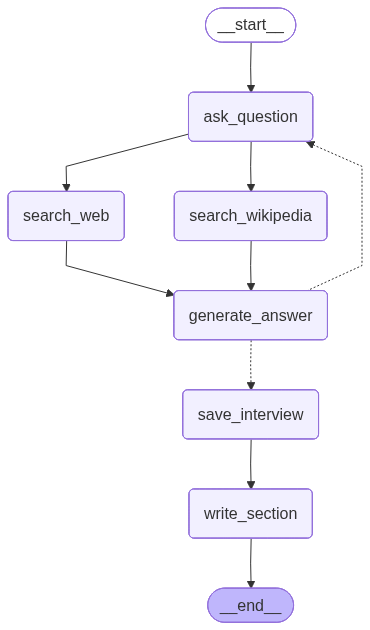

In [71]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [72]:
analyst.persona

'Name: David Lee\nRole: AI Product Manager\nAffiliation: ProductAI\nDescription: Focuses on how Langgraph can accelerate the development and deployment of AI-powered products. Concerned with user experience, monitoring, and the ability to iterate quickly based on user feedback.\n'

In [73]:
from IPython.display import Markdown
messages = [HumanMessage("So you said you are writing an article on MCP")]

thread = {"configurable": {"thread_id": "1"}}

In [74]:
interview = interview_graph.invoke({
    "analyst":analyst, 
    "messages":messages,
    "max_num_turns":2, 
    "section": [],  
    "interview": "" },thread)

*******************************
search_query='Langgraph benefits for AI product development iteration cycles'
*******************************
search_query='Langgraph vs Langchain customer service chatbot iteration speed'


In [75]:
print('section (singular):', interview.get('section'))

section (singular): None


In [76]:
type(interview)

dict

In [77]:
for i,j in interview.items():
    print(i, ":", j)

messages : [HumanMessage(content='So you said you are writing an article on MCP', additional_kwargs={}, response_metadata={}, id='d40b9dc0-97c5-4c78-8525-73c6895b401e'), AIMessage(content='Hi David, I\'m Anya Sharma, a product analyst working on understanding the landscape of AI product development tools. I\'m particularly interested in how Langgraph is being used to accelerate the creation and deployment of AI-powered products. I understand you\'re focused on user experience, monitoring, and rapid iteration, which are all crucial for success.\n\nTo kick things off, could you share a specific example of how Langgraph has enabled a faster iteration cycle for an AI product compared to more traditional development methods? I\'m looking for something beyond just "it\'s faster," but rather a concrete scenario with measurable improvements.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.

In [78]:
Markdown(interview['sections'][0])

## Accelerating AI Product Development with LangGraph: Enhanced User Experience and Iterative Feedback

### Summary

LangGraph, built on top of LangChain, facilitates the development of AI-powered products by enabling developers to create more sophisticated, stateful, and controllable applications [2]. Unlike LangChain, which excels in linear workflows, LangGraph introduces cyclic computational capabilities, allowing AI agents to dynamically loop through processes and make decisions based on evolving conditions [2]. This is particularly useful for applications requiring complex reasoning, multi-agent interactions, and adaptability [1, 4, 6]. LangGraph streamlines the development process by providing a high-level abstraction for building AI applications that involve multiple agents that seamlessly interact [1]. The ability to define actors, their attributes, relationships, and behaviors using a graph-based representation simplifies the creation of advanced chatbots and interactive AI systems [1].

The key benefits of LangGraph include:

1.  **Cyclical and Controllable Workflows:** LangGraph's graph-based structure supports cycles, enabling agents to loop, retry, and reflect on their actions, which is critical for tackling complex problems [1, 2, 5].
2.  **Human-in-the-Loop Debugging:** LangGraph Studio integrates with LangChain’s observability tool (LangSmith), allowing for real-time debugging and faster iteration based on user feedback [4]. This collaborative environment enables teams to diagnose issues, review agent decisions, and improve performance over time [4].
3.  **Complex Multi-Agent Systems:** LangGraph allows developers to precisely control when and how agents interact, which mirrors how human teams work, enabling specialization, parallel effort, and oversight [4, 6].
4.  **State Management:** LangGraph provides explicit state management, making it suitable for production-grade, complex, multi-agent workflows with dynamic control flows [6].

LangGraph is particularly well-suited for applications such as advanced chatbots, interactive AI systems, and complex customer support agents that require dynamic decision-making, loops, and human intervention [1, 7].

### Sources

[1] https://www.ampcome.com/articles/what-is-langgraph-how-it-is-useful-in-building-llm-based-applications
[2] https://medium.com/pythoneers/building-ai-agent-systems-with-langgraph-9d85537a6326
[3] https://medium.com/@techie_chandan/why-langgraph-is-the-future-of-ai-workflows-and-what-you-can-do-with-it-deep-dive-into-e1fd7b5f31fc
[4] https://www.scalablepath.com/machine-learning/langgraph
[5] https://www.metacto.com/blogs/a-developer-s-guide-to-langgraph-building-stateful-controllable-llm-applications
[6] https://duplocloud.com/blog/langchain-vs-langgraph/
[7] https://www.eesel.ai/blog/langchain-vs-langgraph
[8] https://www.designveloper.com/blog/langgraph-vs-langchain-comparison
[9] https://www.leanware.co/insights/langchain-vs-langgraph-comparison
[10] https://www.truefoundry.com/blog/langchain-vs-langgraph

## Third Workflow

In [79]:
from typing_extensions import TypedDict
from typing import List, Annotated
import operator

class ResearchGraphState(MessagesState):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]
    sections: Annotated[list, operator.add]
    introduction: str
    content: str
    conclusion: str
    final_report: str


In [80]:
from langgraph.types import Send

In [81]:
def initiate_all_interview(state:ResearchGraphState):
    human_analyst_feedback = state.get('human_analyst_feedback')
    if human_analyst_feedback:
        return 'create_analyst'
    else:
        topic = state['topic']
        return [Send("conduct_interview",{"analyst":analyst,
                                          "messages":[HumanMessage(
                                              content=f"So you said you are writing an article on {topic}"
                                          )
                                          ]})for analyst in state["analysts"]]

In [82]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

In [83]:
def write_report(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    system_message = report_writer_instructions.format(topic=topic, context = formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")])

    return {"context":report.content}



In [84]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""


In [85]:
def write_introduction(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections = formatted_str_sections)
    intro = llm.invoke([instructions]+[HumanMessage(content=f"write the report introduction")])
    return {'introduction':intro.content}


In [86]:
def write_conclusion(state:ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    instructions = intro_conclusion_instructions.format(topic = topic, formatted_str_sections = formatted_str_sections)
    conclusion = llm.invoke(instructions+[HumanMessage(content=f"write the report conclusion")])
    return {'conclusion':conclusion.content}

In [87]:
def finalize_report(state: ResearchGraphState):
    content = state["content"]

    if content.startswith("## Insights"):
        content =  content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n --- \n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}
        

In [88]:
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback",human_feedback)
builder.add_node("conduct_interview",interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

builder.add_edge(START, "create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interview,["create_analyst","conduct_interview"])
builder.add_edge("conduct_interview","write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion","write_report","write_introduction"],"finalize_report")
builder.add_edge("finalize_report",END)


In [89]:
memory = MemorySaver()

In [90]:
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

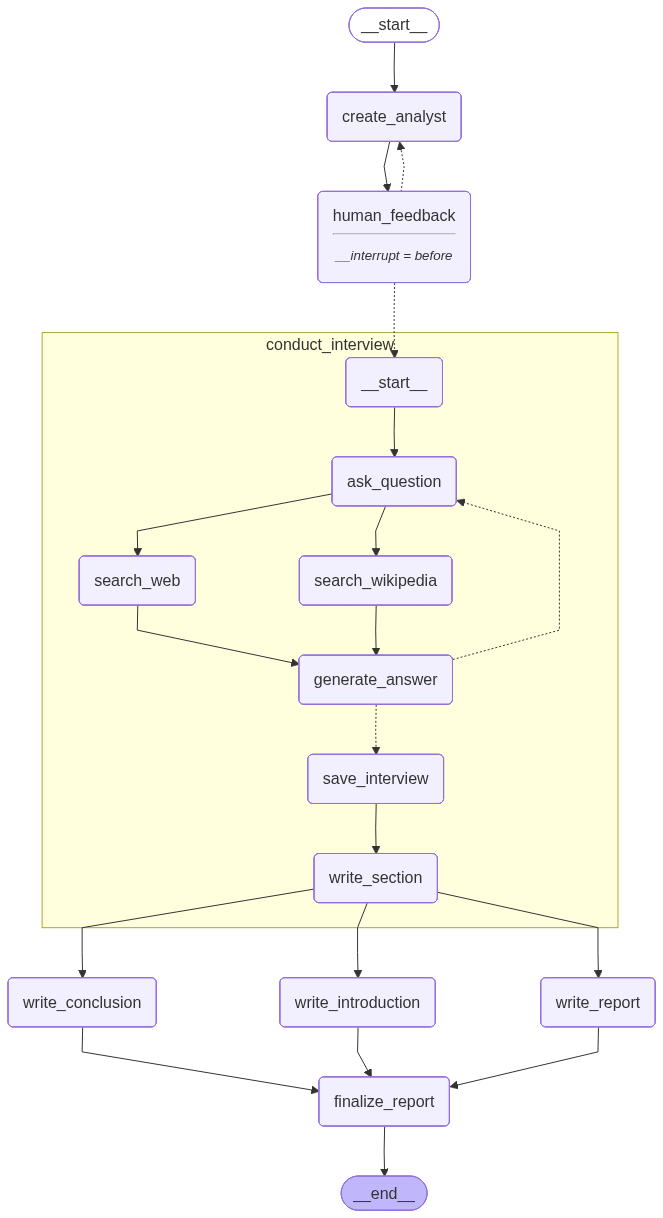

In [91]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [92]:
max_analysts = 3
topic =  "How can generative AI help us to play the cricket?"

In [93]:
thread = {"configurable":{"thread_id":"1"}}

In [96]:
for event in graph.stream({"topic":topic, "max_analysts":max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts','')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-"*50)

Name: Data Deep Dive Dave
Affiliation: Cricket Analytics Inc.
Role: Data Analyst
Description: Focuses on how generative AI can analyze vast cricket datasets to improve player performance and team strategy. He is concerned about data privacy and the ethical use of AI in player development.
--------------------------------------------------
Name: Gameplay Guru Grace
Affiliation: Global Cricket Council
Role: Sports Strategist
Description: Explores how generative AI can simulate matches and predict outcomes to refine gameplay strategies and enhance the fan experience. She is motivated by the potential to make cricket more engaging and competitive.
--------------------------------------------------
Name: Tech Titan Tim
Affiliation: Future Sports Technologies
Role: AI Innovator
Description: Investigates the use of generative AI to create personalized training programs and virtual coaching tools for cricketers. He is driven by the opportunity to democratize access to high-quality cricket trai